In [1]:
import sys
import importlib
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper')
from __init__ import *
import __init__jupyterlab
importlib.reload(__init__jupyterlab)
from __init__jupyterlab import *

import re 
import tqdm
import pickle
import collections
import itertools
import tables
import fbpca

from scipy import sparse
from scipy import stats
from scipy import optimize 
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests

import snmcseq_utils
import CEMBA_clst_utils
import enhancer_gene_utils 
importlib.reload(enhancer_gene_utils)
import plot_utils
importlib.reload(plot_utils)


<module 'plot_utils' from '/cndd/fangming/CEMBA/snmcseq_dev/plot_utils.py'>

In [2]:
import datetime
today = datetime.date.today() #.strftime("%y%m%d")

logger = snmcseq_utils.create_logger()

print(today)

2021-03-18


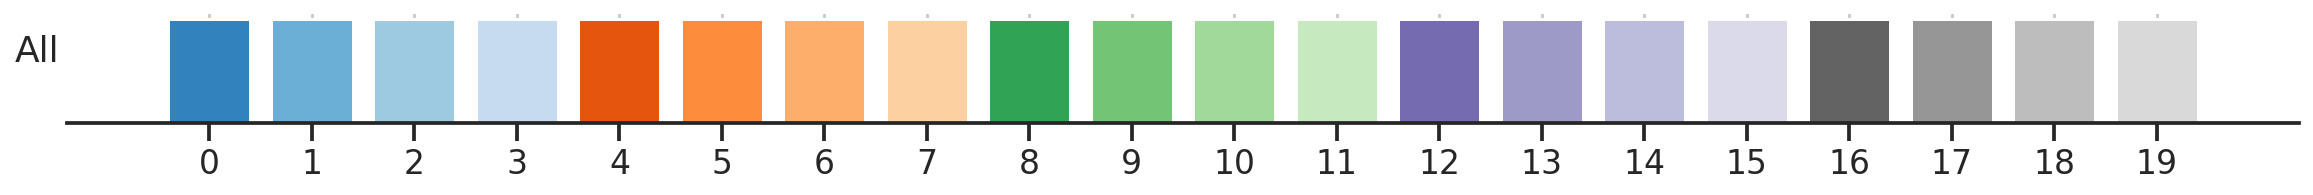

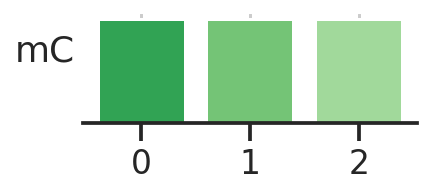

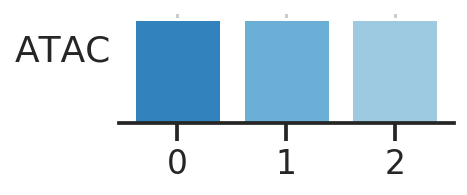

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


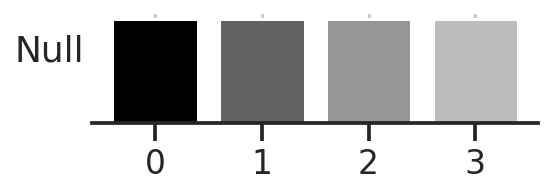

In [3]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

## Get gene by metacell tables 
- RNA
- mCG
- ATAC

In [4]:

CLUSTER_COL = 'cluster_r'

def pipe_corr_analysis_atac(
        common_modx_cells, common_mody_cells,
        cell_cell_knn_xaxis, cell_cell_knn_yaxis,
        common_genes, common_enhancer_regions,
        X, Y, 
        modx_clsts, knn_xy, 
        enhancer_gene_to_eval,
        output_corrs,
        corr_type='pearsonr',
        force=False,
        num_metacell_limit=0,
    ):
    """
    """
    # new cells  
    common_modx_cells_updated = np.intersect1d(common_modx_cells, cell_cell_knn_xaxis)
    common_mody_cells_updated = np.intersect1d(common_mody_cells, cell_cell_knn_yaxis)

    # make sure the original matrices have the correct index
    x_idx = snmcseq_utils.get_index_from_array(common_modx_cells, common_modx_cells_updated)
    y_idx = snmcseq_utils.get_index_from_array(common_mody_cells, common_mody_cells_updated)
    X = X.tocsc()[:, x_idx] 
    Y = Y.tocsc()[:, y_idx]

    # make sure knn_xy, knn_xx have the right cell index
    cell_idx_xaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_xaxis, common_modx_cells_updated)
    cell_idx_yaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_yaxis, common_mody_cells_updated)
    knn_xy = knn_xy.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_yaxis] # x-by-y
    modx_clsts = modx_clsts.reindex(common_modx_cells_updated)

    logging.info("{}_{}_{}_{}".format(knn_xy.shape, modx_clsts.shape, X.shape, Y.shape,))

    for clst_col in modx_clsts.columns: 
        logging.info(clst_col)
        if clst_col.startswith(CLUSTER_COL):
    #         output_corr = output_corrs.format(clst_col)
    #         if not force and os.path.isfile(output_corr):
    #             logging.info("skip {}, already exists...".format(output_corr))
    #             continue # skip the existing file

            # choose one clustering to proceed
            uniq_labels = np.sort(modx_clsts[clst_col].unique()) 
            logging.info("Number of metacells: {}".format(len(uniq_labels)))
            if num_metacell_limit > 0 and len(uniq_labels) > num_metacell_limit:
                logging.info("skip {}, exceeding max num_metacell_limit...".format(len(uniq_labels)))
                continue
            knn_xz = enhancer_gene_utils.turn_cluster_labels_to_knn(modx_clsts[clst_col].values, 
                                                uniq_labels,
                                               )

            # Dec 21,2020
            # gene by metacell (counts)
            gc_rna = X.dot(knn_xz).todense() 
            # normalization (logCPM)
            gc_rna = snmcseq_utils.logcpm(pd.DataFrame(gc_rna)).values

            # Dec 21,2020
            enh_lengths = pd.Series((common_enhancer_regions['end']-common_enhancer_regions['start']).values)
            # enhancer by metacell (counts)
            knn_yz = knn_xy.T.dot(knn_xz)
            ec_atac = Y.dot(knn_yz).todense() 
            # normalization (logTPM)
            ec_atac = snmcseq_utils.logtpm(pd.DataFrame(ec_atac), enh_lengths).values
            logging.info("{} {}".format(gc_rna.shape, ec_atac.shape,))

    #         # corr analysis
    #         output_corr = output_corrs.format(clst_col)
    #         (to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells) = enhancer_gene_utils.compute_enh_gene_corrs(
    #             gc_rna, ec_atac, 
    #             common_genes, np.arange(len(ec_atac)),
    #             enhancer_gene_to_eval['gene'].values, 
    #             enhancer_gene_to_eval['ens'].values, 
    #             output_file=output_corr, corr_type=corr_type, chunksize=100000, verbose_level=0,
    #             )
            return (
                gc_rna, ec_atac, 
                common_genes, np.arange(len(ec_atac)),
                enhancer_gene_to_eval['gene'].values, 
                enhancer_gene_to_eval['ens'].values, 
                '', corr_type, 100000, 0,
            )

def wrap_corr_analysis_atac(
        mod_x, mod_y, 
        input_name_tag, i_sub,
        corr_type='pearsonr',
        force=False,
        num_metacell_limit=0,
    ):
    """
    """
    # (i, k, --r)
    output_corrs = '/cndd2/fangming/projects/scf_enhancers/results/{}_{}_{{}}_{}_corrs.pkl'.format(input_name_tag, i_sub, corr_type)

    # input enh-gene tables, gene-by-cell, enhancer-by-cell matrices
    input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
    input_bundle_dirc = '/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_nov9'
    bundle_fnames = (
        'cell_10x_cells_v3.txt',
        'cell_snatac_gene.txt',

        'gene_10x_cells_v3.txt',
        'enh.tsv',

        'mat_10x_cells_v3.npz',
        'mat_snatac_gene.npz',
    )


    # for knn_xx
    input_knn_dirc = '/cndd2/fangming/projects/miniatlas/results'
    input_modx_clsts = [
        'clusterings_{}_{}_sub{}.tsv.gz'.format(mod_x, input_name_tag, i_sub),
    ]

    # for knn_xy
    input_knn_xy = 'knn_across_{}_{}_{}.npz.{}.npz'.format(input_name_tag, mod_x, mod_y, i_sub) 
    input_knn_cells_xaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_x, input_name_tag, i_sub)
    input_knn_cells_yaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_y, input_name_tag, i_sub)

    # # Load data 
    # input_bundle
    with snmcseq_utils.cd(input_bundle_dirc):
        bundle = []
        for fname in bundle_fnames:
            #  save all as pickle file
            with open(fname, "rb") as fh:
                item = pickle.load(fh)
            bundle.append(item)
            logging.info("{}_{}_{}".format(type(item), item.shape, fname))

    (common_modx_cells, common_mody_cells, 
     common_genes, common_enhancer_regions,
     X, Y, 
    ) = bundle

    # input knn networks 
    with snmcseq_utils.cd(input_knn_dirc):
        # for knn_xx 
        # modx_clsts = pd.read_csv(input_modx_clsts, sep='\t',index_col=0)
        modx_clsts = pd.concat([
            pd.read_csv(fname, sep='\t',index_col=0)
            for fname in input_modx_clsts
        ], axis=1)
        # for knn_xy 
        knn_xy = sparse.load_npz(input_knn_xy)  
        cell_cell_knn_xaxis = np.load(input_knn_cells_xaxis, allow_pickle=True)
        cell_cell_knn_yaxis = np.load(input_knn_cells_yaxis, allow_pickle=True)

        logging.info("{} {} {} {}".format(modx_clsts.shape, knn_xy.shape, 
                                          cell_cell_knn_xaxis.shape, 
                                          cell_cell_knn_yaxis.shape,
                                         )
                    )

    # enhancer-gene linkage
    enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')

    return pipe_corr_analysis_atac(
                common_modx_cells, common_mody_cells,
                cell_cell_knn_xaxis, cell_cell_knn_yaxis,
                common_genes, common_enhancer_regions,
                X, Y, 
                modx_clsts, knn_xy, 
                enhancer_gene_to_eval,
                output_corrs,
                corr_type=corr_type,
                force=force,
                num_metacell_limit=num_metacell_limit,
            )

def pipe_corr_analysis_mc(
        common_rna_cells, common_mc_cells,
        cell_cell_knn_xaxis, cell_cell_knn_yaxis,
        common_genes,
        X, Y_cg, Y_mcg, 
        modx_clsts, knn_xy, 
        enhancer_gene_to_eval,
        output_corrs,
        corr_type='pearsonr',
        force=False,
        num_metacell_limit=0,
    ):
    """
    """
    # new cells  
    common_rna_cells_updated = np.intersect1d(common_rna_cells, cell_cell_knn_xaxis)
    common_mc_cells_updated = np.intersect1d(common_mc_cells, cell_cell_knn_yaxis)

    # make sure the original matrices have the correct index
    x_idx = snmcseq_utils.get_index_from_array(common_rna_cells, common_rna_cells_updated)
    y_idx = snmcseq_utils.get_index_from_array(common_mc_cells, common_mc_cells_updated)
    X = X.tocsc()[:, x_idx] 
    Y_cg = Y_cg.tocsc()[:, y_idx]
    Y_mcg = Y_mcg.tocsc()[:, y_idx] 

    # make sure knn_xy, knn_xx have the right cell index
    cell_idx_xaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_xaxis, common_rna_cells_updated)
    cell_idx_yaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_yaxis, common_mc_cells_updated)
    knn_xy = knn_xy.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_yaxis] # x-by-y
    modx_clsts = modx_clsts.reindex(common_rna_cells_updated)

    logging.info("{}_{}_{}_{}_{}".format(knn_xy.shape, modx_clsts.shape, X.shape, Y_cg.shape, Y_mcg.shape))

    for clst_col in modx_clsts.columns: 
        if clst_col.startswith(CLUSTER_COL):
            
            logging.info(clst_col)
        
#         output_corr = output_corrs.format(clst_col)
#         if not force and os.path.isfile(output_corr):
#             logging.info("skip {}, already exists...".format(output_corr))
#             continue # skip the existing file

            # choose one clustering to proceed
            uniq_labels = np.sort(modx_clsts[clst_col].unique()) 
            logging.info("Number of metacells: {}".format(len(uniq_labels)))
            if num_metacell_limit > 0 and len(uniq_labels) > num_metacell_limit:
                logging.info("skip {}, exceeding max num_metacell_limit...".format(len(uniq_labels)))

            knn_xz = enhancer_gene_utils.turn_cluster_labels_to_knn(modx_clsts[clst_col].values, 
                                                uniq_labels,
                                               )

            # # normalization - such that metacells made of more cells still sums to 1
            # knn_xz = knn_xz.dot(sparse.diags(np.ravel(1.0/knn_xz.sum(axis=0))))
            # # gene by metacell
            # gc_rna = X.dot(knn_xz).todense() 

            # gene by metacell (counts)
            gc_rna = X.dot(knn_xz).todense() 
            # normalization (logCPM)
            gc_rna = snmcseq_utils.logcpm(pd.DataFrame(gc_rna)).values

            # enhancer by metacell (counts cg, mcg)
            knn_yz = knn_xy.T.dot(knn_xz)
            ec_cg = Y_cg.dot(knn_yz).todense() 
            ec_mcg = Y_mcg.dot(knn_yz).todense()  
            logging.info("{} {} {}".format(gc_rna.shape, ec_cg.shape, ec_mcg.shape))

            # mC
            ec_mccg = snmcseq_utils.get_mcc_lite_v4(
                                           pd.DataFrame(ec_cg).astype(np.float32), 
                                           pd.DataFrame(ec_mcg).astype(np.float32), 
                                           base_call_cutoff=5, sufficient_coverage_fraction=0.8, fillna=True)
            logging.info("{}".format(ec_mccg.shape))

#             # corr analysis
#             (to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells) = enhancer_gene_utils.compute_enh_gene_corrs(
#                 gc_rna, ec_mccg, 
#                 common_genes, ec_mccg.index.values,
#                 enhancer_gene_to_eval['gene'].values, 
#                 enhancer_gene_to_eval['ens'].values, 
#                 output_file=output_corr, corr_type=corr_type, chunksize=100000, verbose_level=0,
#                 )
            return (
                gc_rna, ec_mccg, 
                common_genes, ec_mccg.index.values,
                enhancer_gene_to_eval['gene'].values, 
                enhancer_gene_to_eval['ens'].values, 
                '', corr_type, 100000, 0,
                )

def wrap_corr_analysis_mc(
        mod_x, mod_y, 
        input_nme_tag, i_sub,
        corr_type='pearsonr',
        force=False,
        num_metacell_limit=0,
    ):
    """
    """
    # (i, k, --r)
    output_corrs = '/cndd2/fangming/projects/scf_enhancers/results/{}_{}_{{}}_{}_corrs.pkl'.format(input_name_tag, i_sub, corr_type)

    # input enh-gene tables, gene-by-cell, enhancer-by-cell matrices
    input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
    input_bundle_dirc = '/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_nov9'
    bundle_fnames = (
        'cell_10x_cells_v3.txt',
        'cell_snmcseq_gene.txt',

        'gene_10x_cells_v3.txt',
        'enh.tsv',

        'mat_10x_cells_v3.npz',
        'mat_mcg_snmcseq_gene.npz',
        'mat_cg_snmcseq_gene.npz',
    )

    # for knn_xx
    input_knn_dirc = '/cndd2/fangming/projects/miniatlas/results'
    input_modx_clsts = [
        'clusterings_{}_{}_sub{}.tsv.gz'.format(mod_x, input_name_tag, i_sub),
    ]

    # for knn_xy
    input_knn_xy = 'knn_across_{}_{}_{}.npz.{}.npz'.format(input_name_tag, mod_x, mod_y, i_sub) 
    input_knn_cells_xaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_x, input_name_tag, i_sub)
    input_knn_cells_yaxis = 'cells_{}_{}.npy.{}.npy'.format(mod_y, input_name_tag, i_sub)

    # # Load data 
    # input_bundle
    with snmcseq_utils.cd(input_bundle_dirc):
        bundle = []
        for fname in bundle_fnames:
            #  save all as pickle file
            with open(fname, "rb") as fh:
                item = pickle.load(fh)
            bundle.append(item)
            logging.info("{}_{}_{}".format(type(item), item.shape, fname))

    (common_rna_cells, common_mc_cells, 
     common_genes, common_enhancer_regions,
     X, Y_mcg, Y_cg, 
    #  knn_xy, knn_xx,
    ) = bundle

    # input knn networks 
    with snmcseq_utils.cd(input_knn_dirc):
        # for knn_xx 
        # modx_clsts = pd.read_csv(input_modx_clsts, sep='\t',index_col=0)
        modx_clsts = pd.concat([
            pd.read_csv(fname, sep='\t',index_col=0)
            for fname in input_modx_clsts
        ], axis=1)
        # for knn_xy 
        knn_xy = sparse.load_npz(input_knn_xy)  
        cell_cell_knn_xaxis = np.load(input_knn_cells_xaxis, allow_pickle=True)
        cell_cell_knn_yaxis = np.load(input_knn_cells_yaxis, allow_pickle=True)

        logging.info("{} {} {} {}".format(
              modx_clsts.shape, 
              knn_xy.shape, 
              cell_cell_knn_xaxis.shape, 
              cell_cell_knn_yaxis.shape,
              )
             )

    # enhancer-gene linkage
    enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')
    return pipe_corr_analysis_mc(
                common_rna_cells, common_mc_cells,
                cell_cell_knn_xaxis, cell_cell_knn_yaxis,
                common_genes,
                X, Y_cg, Y_mcg, 
                modx_clsts, knn_xy, 
                enhancer_gene_to_eval,
                output_corrs,
                corr_type=corr_type,
                force=force,
                num_metacell_limit=num_metacell_limit,
            )

In [5]:
mod_x, mod_y = '10x_cells_v3', 'snatac_gene'
ka = 30 
knn = 30 
date = "201206"
input_name_tag = 'mop_{}_{}_ka{}_knn{}_{}'.format(mod_x, mod_y, ka, knn, date)
i_sub = '0'

CLUSTER_COL = 'cluster_r25'
res1 = wrap_corr_analysis_atac(
                            mod_x, mod_y, 
                            input_name_tag, i_sub,
                            corr_type='spearmanr',
                            force=False,
                            num_metacell_limit=0,
                    )
gc_rna1, ec_atac = res1[:2]
print(gc_rna1.shape, ec_atac.shape)

mod_x, mod_y = '10x_cells_v3', 'snmcseq_gene'
ka = 30 
knn = 30 
date = "201130"
input_name_tag = 'mop_{}_{}_ka{}_knn{}_{}'.format(mod_x, mod_y, ka, knn, date)
i_sub = '0'
res2 = wrap_corr_analysis_mc(
                            mod_x, mod_y, 
                            input_name_tag, i_sub,
    #                         corr_type='pearsonr',
                            force=False,
                            num_metacell_limit=0,
                    )
gc_rna2, ec_mccg = res2[:2]
print(gc_rna2.shape, ec_mccg.shape)

03/18/2021 11:26:30 AM <class 'numpy.ndarray'>_(69727,)_cell_10x_cells_v3.txt
03/18/2021 11:26:30 AM <class 'numpy.ndarray'>_(135665,)_cell_snatac_gene.txt
03/18/2021 11:26:30 AM <class 'numpy.ndarray'>_(31053,)_gene_10x_cells_v3.txt
03/18/2021 11:26:30 AM <class 'pandas.core.frame.DataFrame'>_(233514, 3)_enh.tsv
03/18/2021 11:27:03 AM <class 'scipy.sparse.csc.csc_matrix'>_(31053, 69727)_mat_10x_cells_v3.npz
03/18/2021 11:27:05 AM <class 'scipy.sparse.csc.csc_matrix'>_(233514, 135665)_mat_snatac_gene.npz
03/18/2021 11:27:06 AM (69727, 41) (69727, 54844) (69727,) (54844,)
03/18/2021 11:27:26 AM (69727, 54844)_(69727, 41)_(31053, 69727)_(233514, 54844)
03/18/2021 11:27:26 AM cluster_r1.0
03/18/2021 11:27:26 AM cluster_r1.2589254117941673
03/18/2021 11:27:26 AM cluster_r1.5848931924611136
03/18/2021 11:27:26 AM cluster_r1.9952623149688797
03/18/2021 11:27:26 AM cluster_r2.51188643150958
03/18/2021 11:27:26 AM cluster_r3.1622776601683795
03/18/2021 11:27:26 AM cluster_r3.981071705534973
03

(31053, 256) (233514, 256)


03/18/2021 11:27:50 AM <class 'scipy.sparse.csc.csc_matrix'>_(31053, 69727)_mat_10x_cells_v3.npz
03/18/2021 11:28:03 AM <class 'scipy.sparse.csc.csc_matrix'>_(233514, 9931)_mat_mcg_snmcseq_gene.npz
03/18/2021 11:28:33 AM <class 'scipy.sparse.csc.csc_matrix'>_(233514, 9931)_mat_cg_snmcseq_gene.npz
03/18/2021 11:28:34 AM (55912, 41) (55912, 7499) (55912,) (7499,)
03/18/2021 11:28:48 AM (55912, 7497)_(55912, 41)_(31053, 55912)_(233514, 7497)_(233514, 7497)
03/18/2021 11:28:48 AM cluster_r25.11886431509581
03/18/2021 11:28:48 AM Number of metacells: 248
03/18/2021 11:29:42 AM (31053, 248) (233514, 248) (233514, 248)
03/18/2021 11:29:44 AM Imputing data... (No effect if sufficient_coverage_fraction=1)
03/18/2021 11:29:45 AM (233512, 248)


(31053, 248) (233512, 248)


In [6]:
# enhancer_gene_pairs
f = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
enh_gene_table = pd.read_csv(f, sep='\t')
print(enh_gene_table.shape)

(2589994, 18)


In [7]:
ec_mccg.tail()

0         1         2         3         4         5         6    \
233509  0.024564  0.020045  0.754647  0.636523  0.827143  0.880168  0.818412   
233510  0.827608  0.972543  0.996793  0.987494  0.872891  0.920969  0.883171   
233511  0.171004  0.069895  0.978632  0.994764  0.979430  0.971857  0.925962   
233512  0.943284  0.400000  0.989529  1.000000  1.000000  1.000000  1.000000   
233513  0.953065  0.892268  0.999457  1.000000  0.865772  0.650622  0.780350   

             7         8         9    ...       238       239       240  \
233509  0.857061  0.929900  0.667137  ...  0.793713  0.800481  0.739035   
233510  0.204075  0.925007  0.569387  ...  0.524786  0.916499  0.823464   
233511  0.891357  0.965318  0.911102  ...  0.937132  0.989209  0.965630   
233512  0.901667  1.000000  1.000000  ...  0.909910  1.000000  0.914894   
233513  0.994978  0.791262  0.316273  ...  0.943452  0.867647  0.768987   

             241       242       243       244       245       246       247  
233509  0.822034  0.798982  0.040000  0.808732  0.870712  0.631757  0.750000  
233510  0.303293  0.538686  0.781482  0.904624  0.255034  0.594771  0.476744  
233511  0.981651  0.940803  0.293144  0.961102  0.887755  0.838150  0.830508  
233512  0.930818  0.880000  0.830303  1.000000  0.813433  1.000000  0.923077  
233513  0.949405  0.971503  0.928870  0.650206  0.992509  0.883178  0.837838  

[5 rows x 248 columns]

In [21]:
res2[0]
res2[1]
res2[3]

array([     0,      1,      2, ..., 233511, 233512, 233513])

## analysis

- shuffle enhancers and control for
- distance to nearest gene
- GC_content
- ...

In [8]:
def plot_routine(res_corrs1, res_corrs2, title1, title2, corr_type, ylim1=[], ylim2=[]):
    """
    """
    # output = output_figures.format('hist_corr_both.pdf')
    
    bins = np.linspace(-1, 1, 201)
    
    fig = plt.figure(figsize=(5*2, 5))
    gs = fig.add_gridspec(3, 2)
    axs = np.array([[fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),],
                    [fig.add_subplot(gs[1:, 0]), fig.add_subplot(gs[1:, 1]),],
                   ])
    for j, (res_corrs, title) in enumerate(zip([res_corrs1, res_corrs2], 
                                             [title1, title2],
                                        )):
        KB = 1000
        labels_base = [
                  'shuffled metacells',
                  'shuffled genes',
                  'shuffled enhs',
                  'shuffled enhs bygroups',
                  '<500kb',
                  '<100kb',
                 ] 
        # corr1
        labels = [label+' mCG-RNA' for label in labels_base]
        corr_tracks = [
               res_corrs['corr_shuff_cells'].values,
               res_corrs['corr_shuff'].values,
               res_corrs['corr_shuff_enhs'].values,
               res_corrs['corr_shuff_enhs_bygroups'].values,
               res_corrs.loc[res_corrs['dist']<=500*KB, 'corr'].values,
               res_corrs.loc[res_corrs['dist']<=100*KB, 'corr'].values,
              ]
        colors = [colors_null[1], 
                  colors_null[0], 
                  colors_null[2],
                  'r',
                  colors_mc[1], 
                  colors_mc[0],
                 ]
    
        ymax = 0
        ax_col = axs[:,j]
        for ax in ax_col:
            for i, track in enumerate(corr_tracks):
                _y, _x, _ = ax.hist(track, bins=bins, density=True, label=labels[i], histtype='step', color=colors[i])
                ymax = max(ymax, np.max(_y))
            _handles, _labels = ax.get_legend_handles_labels()
            _handles = [mpl.lines.Line2D([], [], c=h.get_edgecolor()) for h in _handles]
            
        ax1, ax2 = ax_col
        # ylims
        if not len(ylim1): ylim1 = [0.9*ymax, 1.1*ymax]
        if not len(ylim2): ylim2 = [0, 0.2*ymax] 
        # set slanted y axis
        plot_utils.set_broken_yaxis(ax1, ax2, ylim1, ylim2)
        # limit number of y ticks
        ax1.yaxis.set_major_locator(mtick.MaxNLocator(2))
        ax2.yaxis.set_major_locator(mtick.MaxNLocator(4))
        # labels
        ax1.set_title(title)
        ax2.set_xlabel('{} correlation'.format(corr_type))
        ax2.set_ylabel('Density')

        
    ax.legend(_handles, _labels, bbox_to_anchor=(1,1))
    plt.show()

In [9]:
import enhancer_gene_utils 
importlib.reload(enhancer_gene_utils)

<module 'enhancer_gene_utils' from '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper/enhancer_gene_utils.py'>

In [10]:
y_gc = gc_rna2 #- np.mean(gc_rna2, axis=0)
x_ec = ec_mccg
print(x_ec.shape, y_gc.shape)

(233512, 248) (31053, 248)


In [11]:
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/enhs_list_annotated.tsv' 
enh_annot = pd.read_csv(f, sep='\t', index_col=0)
print(enh_annot.shape)
enh_annot.head()

(233514, 16)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


chr    start      end  length chrom   center trpt_chr  trpt_start  \
index                                                                       
0      chr1  3083769  3083816      47     1  3083792     chr1     3073253   
1      chr1  3112234  3112467     233     1  3112350     chr1     3102016   
2      chr1  3112770  3112986     216     1  3112878     chr1     3102016   
3      chr1  3113717  3114035     318     1  3113876     chr1     3102016   
4      chr1  3118790  3118935     145     1  3118862     chr1     3102016   

       trpt_end strand               trpt_id          trpt_name  \
index                                                             
0       3073254      +  ENSMUST00000193812.1  4933401J01Rik-201   
1       3102017      +  ENSMUST00000082908.1        Gm26206-201   
2       3102017      +  ENSMUST00000082908.1        Gm26206-201   
3       3102017      +  ENSMUST00000082908.1        Gm26206-201   
4       3102017      +  ENSMUST00000082908.1        Gm26206-201   

                    gene_id      gene_name   dist   GC_frac  
index                                                        
0      ENSMUSG00000102693.1  4933401J01Rik  10516  0.553191  
1      ENSMUSG00000064842.1        Gm26206  10218  0.502146  
2      ENSMUSG00000064842.1        Gm26206  10754  0.351852  
3      ENSMUSG00000064842.1        Gm26206  11701  0.377358  
4      ENSMUSG00000064842.1        Gm26206  16774  0.496552

In [25]:
pd.cut(enh_annot.reindex(res2[3])['GC_frac'], 3).values

[(0.389, 0.694], (0.389, 0.694], (0.0824, 0.389], (0.0824, 0.389], (0.389, 0.694], ..., (0.0824, 0.389], (0.389, 0.694], (0.0824, 0.389], (0.389, 0.694], (0.389, 0.694]]
Length: 233512
Categories (3, interval[float64]): [(0.0824, 0.389] < (0.389, 0.694] < (0.694, 1.0]]

In [12]:
# run_results
# regression (applied to each gene and enh pair) -- correlate gene-enh
rdate = 'Mar2'

enh_gc_groups = pd.cut(enh_annot.reindex(res2[3])['GC_frac'], 3)
enh_dist_groups = pd.cut(enh_annot.reindex(res2[3])['dist'], 3)
configs = [
    (y_gc, x_ec, enh_gc_groups.values, 
     'spearmanr', 'test_ctrl_gc_mcrna_spearmanr_{}.pkl'.format(rdate)),
    
    (y_gc, x_ec, enh_dist_groups.values,  
     'spearmanr', 'test_ctrl_dist_mcrna_spearmanr_{}.pkl'.format(rdate)),
]

for config in configs:
    y, x, enhancer_groups, corr_type, output_fname = config
    # # corr analysis
    output_file = ('/cndd2/fangming/projects/scf_enhancers/results_jan2021/{}'.format(output_fname))
    print(output_file)
    
    print('enhancer groups', len(enhancer_groups))
    output = enhancer_gene_utils.compute_enh_gene_corrs(
        y, x,
        res2[2], res2[3],
        res2[4], res2[5],
        enhancer_groups=enhancer_groups.values,
        output_file=output_file, corr_type=corr_type,
        shuff_enhs=True,
    )

/cndd2/fangming/projects/scf_enhancers/results_jan2021/test_ctrl_gc_mcrna_spearmanr_Mar2.pkl
enhancer groups 233512


AttributeError: 'Categorical' object has no attribute 'values'

In [ ]:
# retreve results
# regression (applied to each gene and enh pair) -- correlate gene-enh
rdate = 'Mar2'
configs = [
    ('spearman_mcrna_ctrl_gc', y_gc, x_ec, enh_gc_groups, 
     'spearmanr', 'test_ctrl_gc_mcrna_spearmanr_{}.pkl'.format(rdate)),
    
    ('spearman_mcrna_ctrl_dist', y_gc, x_ec, enh_dist_groups, 
     'spearmanr', 'test_ctrl_dist_mcrna_spearmanr_{}.pkl'.format(rdate)),
]

res_corrs_all = {}
for config in configs:
    label, y, x, enh_groups, corr_type, output_fname = config
    # # corr analysis
    output_file = ('/cndd2/fangming/projects/scf_enhancers/results_jan2021/{}'.format(output_fname))
    print(output_file)
    with open(output_file, 'rb') as fh:
        (to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells, 
         corrs_shuffled_enhs,
         corrs_shuffled_enhs_bygroups,
        ) = pickle.load(fh)
    
    to_evals = enh_gene_table
    res_corrs = to_evals[to_correlate].copy()
    res_corrs['enh_group'] = enh_groups.reindex(res_corrs['ens']).values 
    res_corrs['corr'] = corrs 
    res_corrs['corr_shuff'] = corrs_shuffled
    res_corrs['corr_shuff_cells'] = corrs_shuffled_cells
    res_corrs['corr_shuff_enhs'] = corrs_shuffled_enhs
    res_corrs['corr_shuff_enhs_bygroups'] = corrs_shuffled_enhs_bygroups
    
    res_corrs_all[label] = res_corrs

In [ ]:
# res_corrs[['GC_frac', 'dist']] = enh_annot.loc[res_corrs['ens'])[['GC_frac', 'dist']]
res_corrs.head()

In [ ]:
plot_routine(res_corrs_all['spearman_mcrna_ctrl_gc'], 
             res_corrs_all['spearman_mcrna_ctrl_dist'], 
             'normal', 'normal', 'Spearman', 
             ylim1=[5, 6.5], ylim2=[0, 3],
            )

# display different groups 

In [ ]:
def simple_plot_routine(res_corrs, title, corr_type, ylim1=[], ylim2=[], bins=np.linspace(-1, 1, 201)):
    """
    """
    # output = output_figures.format('hist_corr_both.pdf')
    
    fig = plt.figure(figsize=(5*1, 5))
    gs = fig.add_gridspec(3, 1)
    axs = np.array([fig.add_subplot(gs[0, 0]), 
                    fig.add_subplot(gs[1:, 0]), 
                   ])
    
    KB = 1000
    
    corr_tracks = [
#            res_corrs['corr_shuff_cells'].values,
           res_corrs['corr_shuff'].values,
           res_corrs['corr_shuff_enhs'].values,
           res_corrs['corr_shuff_enhs_bygroups'].values,
           res_corrs.loc[res_corrs['dist']<=500*KB, 'corr'].values,
           res_corrs.loc[res_corrs['dist']<=100*KB, 'corr'].values,
          ]
    
    labels = [
#               'shuffled metacells',
              'shuffled genes',
              'shuffled enhs',
              'shuffled enhs bygroups',
              '<500kb',
              '<100kb',
             ] 
    colors = [
#               colors_null[1], 
              colors_null[0], 
              colors_null[2],
              'r',
              colors_mc[1], 
              colors_mc[0],
              
              'C0', 'C1', 'C3'
             ]

    for grp, df_grp in res_corrs.groupby('enh_group'):
#         track = df_grp.loc[df_grp['dist']<=100*KB, 'corr'].values
        track = df_grp['corr_shuff_enhs_bygroups'].values
        corr_tracks.append(track)
        labels.append(grp)
        
    ymax = 0
    for ax in axs:
        for i, track in enumerate(corr_tracks):
            _y, _x, _ = ax.hist(track, bins=bins, density=True, label=labels[i], histtype='step', color=colors[i])
            ymax = max(ymax, np.max(_y))
        _handles, _labels = ax.get_legend_handles_labels()
        _handles = [mpl.lines.Line2D([], [], c=h.get_edgecolor()) for h in _handles]

    ax1, ax2 = axs
    # ylims
    if not len(ylim1): ylim1 = [0.9*ymax, 1.1*ymax]
    if not len(ylim2): ylim2 = [0, 0.2*ymax] 
    # set slanted y axis
    plot_utils.set_broken_yaxis(ax1, ax2, ylim1, ylim2)
    # limit number of y ticks
    ax1.yaxis.set_major_locator(mtick.MaxNLocator(2))
    ax2.yaxis.set_major_locator(mtick.MaxNLocator(4))
    # labels
    ax1.set_title(title)
    ax2.set_xlabel('{} correlation'.format(corr_type))
    ax2.set_ylabel('Density')
        
    ax.legend(_handles, _labels, bbox_to_anchor=(1,1))
    plt.show()

In [ ]:
def simple_plot_routine_cdf(res_corrs, title, corr_type, ylim1=[], ylim2=[], bins=np.linspace(-1, 1, 201), output=''):
    """
    """
    
    KB = 1000
    
    track_configs = [
#         ('<100kb', res_corrs.loc[res_corrs['dist']<=100*KB, 'corr'].values, colors_mc[1]), 
#         ('<500kb', res_corrs.loc[res_corrs['dist']<=500*KB, 'corr'].values, colors_mc[0]), 
#         ('shuffled metacells', res_corrs['corr_shuff_cells'].values, colors_null[1], ),
        
#         ('shuffled genes', res_corrs['corr_shuff'].values, colors_null[0], ),
#         ('shuffled enhs', res_corrs['corr_shuff_enhs'].values, colors_null[0], ),
#         ('shuffled enhs by group', res_corrs['corr_shuff_enhs_bygroups'].values, colors_null[0], ),
#         ()
    ]
    
    # enhs
    grad_colors = snmcseq_utils.get_grad_colors(6, cmap='Greens_r')[1:]
    for j, (grp, df_grp) in enumerate(res_corrs.groupby('enh_group')):
        track = df_grp.loc[df_grp['dist']<=100*KB, 'corr'].values
        track_configs.append(
            ("<100kb GC content {}".format(grp), track, grad_colors[j])
        )

    # shuffled enhs
    grad_colors = snmcseq_utils.get_grad_colors(5, cmap='Reds_r')[1:]
    for j, (grp, df_grp) in enumerate(res_corrs.groupby('enh_group')):
        track = df_grp['corr_shuff_enhs_bygroups'].values
        track_configs.append(
            ("shuffled enhs GC content {}".format(grp), track, grad_colors[j])
        )
        
        
    fig = plt.figure(figsize=(3*5, 3*2))
    gs = fig.add_gridspec(2, 5)
    axs = np.array([
        fig.add_subplot(gs[0:2, 0:2]),
        
        fig.add_subplot(gs[0, 2]),
        fig.add_subplot(gs[0, 3]),
        fig.add_subplot(gs[0, 4]),
        
        fig.add_subplot(gs[1, 2]),
        fig.add_subplot(gs[1, 3]),
        fig.add_subplot(gs[1, 4]),
    ])
        
#     fig, axs = plt.subplots(2, 3, figsize=(3*3, 3*2), sharex=True, sharey=True)
    
    
    # one plot
    ax = axs[0]
    for i, config in enumerate(track_configs):
        label, track, color = config
        _y, _x = np.histogram(track, bins=bins,)
        ax.plot(_x[1:], np.cumsum(_y)/np.sum(_y), label=label, color=color, linewidth=3, alpha=1)
        _handles, _labels = ax.get_legend_handles_labels()
    # labels
    ax.set_title(title)
    ax.set_xlabel('{} correlation'.format(corr_type))
    ax.set_ylabel('Cumulative fraction of pairs')
        
    ax.legend(_handles, _labels, bbox_to_anchor=(1,-0.2))
    
    # many plots
    for j, ax in enumerate(axs[1:]):
        for i, config in enumerate(track_configs):
            label, track, color = config
            color='gray'
            _y, _x = np.histogram(track, bins=bins,)
            ax.plot(_x[1:], np.cumsum(_y)/np.sum(_y), label=label, color=color, linewidth=1, alpha=1)
            
        label, track, color = track_configs[j]
        _y, _x = np.histogram(track, bins=bins,)
        ax.plot(_x[1:], np.cumsum(_y)/np.sum(_y), label=label, color=color, linewidth=3, alpha=1)
        ax.set_xticks([-1, 1])
        ax.set_yticks([0, 1])
    
    fig.subplots_adjust(wspace=0.2, hspace=0.2)
    if output:
        snmcseq_utils.savefig(fig, output)
    plt.show()
    

In [ ]:
simple_plot_routine_cdf(res_corrs_all['spearman_mcrna_ctrl_gc'], 'GC content comparison', 'Spearman', 
                        bins=np.linspace(-1, 1, 51), 
                        output='/cndd2/fangming/projects/scf_enhancers/results_jan2021/cdf_control_gc_content.pdf'
                        )

In [ ]:
simple_plot_routine_cdf(res_corrs_all['spearman_mcrna_ctrl_dist'], 'Control for distance to the nearest gene', 'Spearman', 
                        bins=np.linspace(-1, 1, 51),
                        output='/cndd2/fangming/projects/scf_enhancers/results_jan2021/cdf_control_nngene.pdf'
                        )

In [ ]:
# simple_plot_routine(res_corrs_all['spearman_mcrna_ctrl_gc'], 'normal', 'Spearman', 
#                     ylim1=[5, 6.5], ylim2=[0, 3],
#                     bins=np.linspace(-1, 1, 51)
#                 )